In [1]:
#|default_exp conv

# Convolutions

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch, logging
import pandas as pd,matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor, nn
from torch.utils.data import DataLoader,default_collate
from typing import Mapping

In [3]:
logging.disable(logging.WARNING)
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
# !pip install -e ..
from miniai.training import *
from miniai.datasets import *

In [5]:
if torch.cuda.is_available():
    def_device = torch.device("cuda")
    print("✅ CUDA device is available.")
elif torch.backends.mps.is_available():
    def_device = torch.device("mps")
    print("✅ MPS device is available.")
else:
    def_device = torch.device("cpu")
    print("🖥️ Using CPU (neither CUDA nor MPS available).")

print(f"Selected device: {def_device}")

✅ MPS device is available.
Selected device: mps


In [6]:
with gzip.open(Path('data')/'mnist.pkl.gz', 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that. Finding the edges in an image is a very common task in computer vision. To do it, we use a *convolution*, which requires only multiplication and addition.

### Understanding the Convolution Equations

To explain the math behind convolutions showing [CNNs from different viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c).
<br>
Here's the input:
<img alt="The image" width="75" src="images/att_00032.png">

Here's our kernel:
<img alt="The kernel" width="55" src="images/att_00033.png">
Since the filter fits in the image four times, we have four results:
<img alt="The activations" width="52" src="images/att_00034.png">

<img alt="Applying the kernel" width="366" caption="Applying the kernel" id="apply_kernel" src="images/att_00035.png">

<img alt="The equation" width="436" caption="The equation" id="eq_view" src="images/att_00036.png">

In [7]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

mpl.rcParams['figure.dpi'] is a setting in Matplotlib that controls the dots per inch (DPI) for figures, i.e., it determines the resolution or clarity of the figures you create.

In [8]:
mpl.rcParams['figure.dpi'] = 30

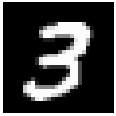

In [9]:
im3 = x_imgs[7]
show_image(im3);

In [10]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

We're going to call the `top_edge` matrix our $kernel$.

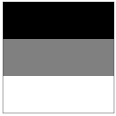

In [11]:
show_image(top_edge, noframe=False);

The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:
<br>
$\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}$
<br>
it will return $-a1-a2-a3+a7+a8+a9$.

Let's grab the first 13 rows and 23 columns of the image to a dataframe and use `Greys` conditional formatting.
<br>
`df.style` accesses the Styler object, which allows you to format and style the DataFrame.
<br>
`.format(precision=2)`    Formats all numeric values to show 2 decimal places.
<br> 
`.set_properties(**{'font-size': '7pt'})`     Sets the font size of the entire DataFrame display to 7pt.
<br>
`.background_gradient('Greys')`     Applies a background color gradient using the 'Greys' colormap. 
Higher (lower) values will have darker (lighter) shades of grey.

In [12]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'8pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


If we take rows `[3:6]`, columns `[14:17]` and multiply it by the `top_edge` kernel it gives us a
fairly large positive value; This is going to find the top Edge.
This is a DOT product, an element-wise multiplication followed by a sum.

In [13]:
df2 = pd.DataFrame(im3[3:6,14:17])
df2.style.format(precision=2).set_properties(**{'font-size':'8pt'}).background_gradient('Greys')

,0,1,2
0,0.00,0.00,0.00
1,0.00,0.00,0.00
2,1.00,0.99,0.99


In [14]:
(im3[3:6,14:17] * top_edge).sum().item()

2.97265625

In [15]:
df2 = pd.DataFrame(im3[7:10,14:17])
df2.style.format(precision=2).set_properties(**{'font-size':'8pt'}).background_gradient('Greys')

,0,1,2
0,0.99,0.98,0.98
1,0.52,0.52,0.52
2,0.00,0.00,0.00


In [16]:
(im3[7:10,14:17] * top_edge).sum().item()

-2.95703125

We would like to apply the `top_edge` kernel to every single 3x3 section.
The `apply_kernel()` function takes a `row, column` from the input, 
and a 3x3 tensor as a `kernel` and does that multiplication `.sum()`

In [17]:
def apply_kernel(row, col, kernel): 
    return (im3[row-1:row+2,col-1:col+2] * kernel).sum()

For example, we can replicate this one by calling `apply_kernel(4,15,top_edge)` (the center of that 3x3 grid area),
and get the same number 2.9727.

In [18]:
apply_kernel(4,15,top_edge).item()

2.97265625

Here is how we slide the application of the kernel. Notice that we are "loosing" 2 cells in the output.
Notice that as we are putting our 3x3 through this 5x5, there's only 3 places that we can put it going across, 
not five places because we need some kind of edge. <br>
<img src="images/chapter9_nopadconv.svg" id="nopad_conv" caption="Applying a kernel across a grid" alt="Applying a kernel across a grid" width="400">

Now we could apply that kernel to every one of the 3x3 windows in this 28x28 image.
We're going to be sliding over like above but now over a 28x28 input.
<br>
To get all of the coordinates let's simplify to a 5x5.
We create a list comprehension that takes `i` through every value in `range(5)`
and for each of those we take `j` for every value in range(5).

In [19]:
[[(i,j) for j in range(5)] for i in range(5)] #the indexes of the pixels

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

We get a list of lists containing all of the coordinates. This is a list comprehension in a list comprehension.

We go from 1 to 26 and for each of those go through from 1 to 26 again and call `apply_kernel()`.
That's going to give us the result of applying that convolutional kernel to
every one of those coordinates. 
Below the result, highlighting the top edges.

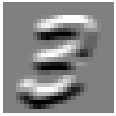

In [20]:
rng = range(1,27) #Notice range indicates the "loss" of 2 pixels
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

We can do another convolution this time with the `left_edge` tensor,
which looks as a rotated version of the `top_edge` tensor.

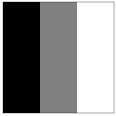

In [21]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()
show_image(left_edge, noframe=False);

We apply the `left_edge` kernel passing the corresponding tensor for the same list comprehension in a list comprehension.
Now highlighting all of the left edges in the digit.

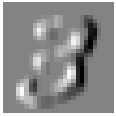

In [22]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

A 2x2 kernel can be looped over an image creating these outputs. 
In the process we are losing the outermost pixels of our image.
We'll learn about how to fix that later.

<img alt="Result of applying a 3×3 kernel to a 4×4 image" width="782" caption="Result of applying a 3×3 kernel to a 4×4 image (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_ex_four_conv" src="images/att_00028.png">

### Convolutions in PyTorch
Speeding up.

In [23]:
import torch.nn.functional as F
import torch

What to do if you have [2 months to complete your thesis](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo)? Use [im2col](https://hal.inria.fr/inria-00112631/).

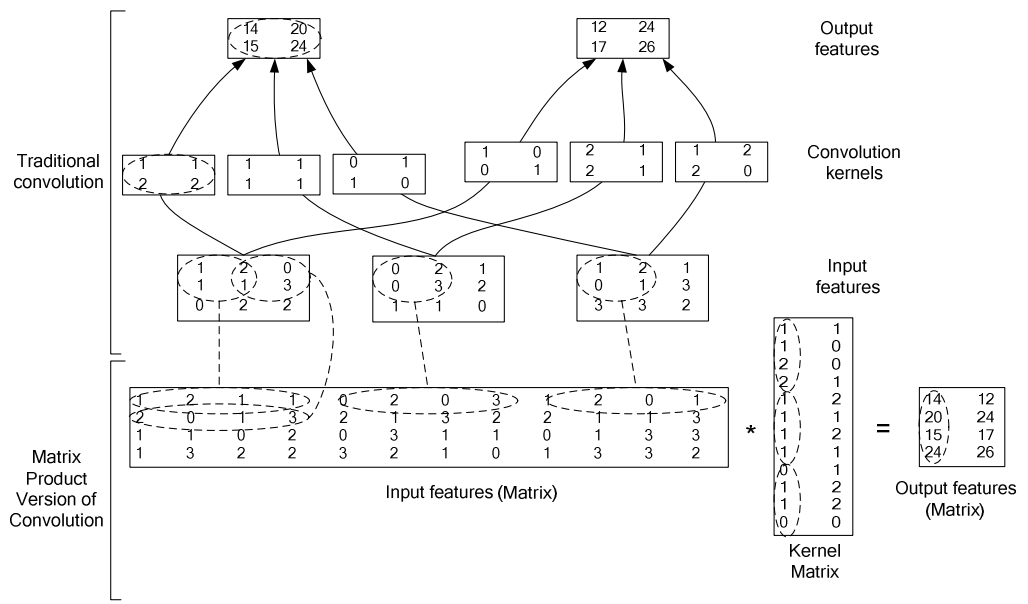

Here's a sample [numpy implementation](https://github.com/3outeille/CNNumpy/blob/5394f13e7ed67a808a3e39fd381f168825d65ff5/src/fast/utils.py#L360) of im2col.
(We're cheating a little, as implementing that is boring.... so instead we linked to a numpy implementation.)
It's a little bit tedious with repeats and tiles and reshapes, etc. 

```python 
torch.nn.functional.unfold(input, kernel_size, dilation=1, padding=0, stride=1)
``` 
Pytorch's `F.unfold` lets us extract sliding local blocks (windows) from a batched input tensor, like an image. 
Given an input of shape (N, C, H, W) (e.g. a batch of images), 
`F.unfold` extracts sliding windows of size `kernel_size` from it and returns a 2D tensor of shape:
`(N, C × kernel_height × kernel_width, L)` where `L` = number of sliding blocks (i.e. how many times the kernel fits in the image, given stride, padding, etc.)
<br>
It's "making overlapping image patches".
Below we add two `None` unit leading dimensions to it (for the `N, C` dimensions).
Then we `unfold` the input `im3` (28x28) for a 3x3 block and that gives us a 9x676 unfolded shape.

In [24]:
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]
im3.shape, inp_unf.shape

(torch.Size([28, 28]), torch.Size([9, 676]))

We take a kernel (`left_edge`) and flatten it out into a vector using `.view` to change its shape.
-1 means dump everything into this dimension.
It creates `w`, a length 9 vector.

In [25]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

Now we can do the matrix multiply `@` of the kernel `w` (weights) by the unrolled input features `inp_unf`
That gives us a 676 long vector.

In [26]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

We can then view `out_unf` as 26x26, and we get back our left Edge tensor result.

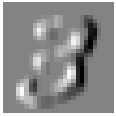

In [27]:
out = out_unf.view(26,26)
show_image(out);

This is how we can create an implementation of convolutions from scratch.
But we're not always creating the GPU optimized versions from scratch.

In [28]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng]);

1.91 ms ± 155 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we use `apply_kernel` we get ~ 2 milliseconds,
if we use unfold with matrix multiplier `@` we get ~ 2 orders of magnitude (150x) times faster.

In [29]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

10 μs ± 3.91 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Pytorch's `conv2D` is about the same speed... but would also work on a GPU.
**NB** this is a small image, need to experiment with bigger ones to measure difference in speeds.

In [30]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

The slowest run took 6.23 times longer than the fastest. This could mean that an intermediate result is being cached.
4.21 μs ± 4.39 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We do the same for diagonal edges `diag1_edge` and `diag2_edge`.

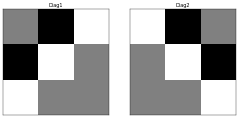

In [31]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

fig,axs = subplots(1,2, imsize=5)
show_image(diag1_edge, axs[0], noframe=False, title="Diag1")
show_image(diag2_edge, axs[1],noframe=False, title="Diag2");

Lets take the first 16 images into a batch `xb`.

In [32]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

Lets stack all the 4 edges, and add an extra dimension for the channel. (NB: [:None] Adds a new dimension after the first one).

In [33]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

To get good parallel (eg GPU) acceleration we're doing a bunch of kernels and images all at once across all of their pixels.

In [34]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

The output shape shows 16 images in the mini-batch, 4 kernels, and 26×26 edge maps 
(we started with 28×28 images, but lost one pixel from each side). 
We get the same results as when we did this manually:

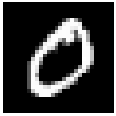

In [35]:
img0 = xb[1,0]
show_image(img0);

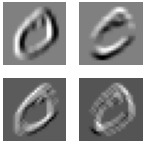

In [36]:
show_images([batch_features[1,i] for i in range(4)])

### Strides and Padding

#### Padding
We can add padding to deal with the problem of losing one pixel on each side.
Rather than starting our window as before, we start it as seen in the Figure below.
For the 3 "imaginary" pixels on the left the simplest approach is "padding", to take their value as 0.
(There are alternative ways, e.g., assume they're the same as their neighbour.) 
With appropriate padding, we can ensure that the output activation map is the same size as the original image.

<img src="images/chapter9_padconv.svg" id="pad_conv" caption="A convolution with padding" alt="A convolution with padding" width="600">

With a 5×5 input (blue), 4×4 kernel (gray), and 2 pixels of padding, we end up with a 6×6 (green) activation map.
<img alt="A 4×4 kernel with 5×5 input and 2 pixels of padding" width="783" caption="A 4×4 kernel with 5×5 input and 2 pixels of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="four_by_five_conv" src="images/att_00029.png">

We normally use **odd** numbered kernels, even numbered kernels are not used often;
Odd numbered edge size kernels are easier to deal with to ensure we end up with the same sizes we start with.
For example a 3x3 kernel and one pixel of padding we get back the same size we start with.
Same for a 5x5 with three pixels of padding. 

#### stride
If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is `ks//2`.
We could move over two pixels after each kernel application. This is known as a *stride-2* convolution.
We've got a odd numbered size `ks by ks` size kernel then `ks` truncate divide two ((that's what `//` means)) will give the right size.
<br>
We can move the window across by a different amount (the **stride**) each time.
Below we move it by a stride-2.
stride-2 convolutions reduce the dimensionality of the input by a factor of two.
We often want to do that size reduction, e.g., with an autoencoder and for most classification architectures.

<img alt="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding" width="774" caption="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_by_five_conv" src="images/att_00030.png">

## Creating the CNN
Let's create a convnet using these approaches.
The size of our training set, `n, m, c, nh` are all the same as with our sequential linear models.

In [37]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [38]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

With our earlier MLPs we went from the number of pixels to the number of hidden `nh`, and then from `nh` to the number of outputs `c`.
We can't use the same simple approach now, because the output is different.
Previously it was 10 probabilities for each item in the batch, but now it is 10 probabilities for each item in our batch for each of the 28x28 pixels.
Below `broken_cnn` ilustrates using Pytorch's `nn`.

In [39]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [40]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

`conv()` creates a 2D convolutional layer (`nn.Conv2d`) with specified input channels (`ni`), output channels (`nf`), kernel size (`ks` - default 3), and stride (`stride` - default 2). It adds padding to maintain spatial dimensions. Optionally (default: True), it appends a ReLU activation function using `nn.Sequential`. It returns the resulting convolutional layer (potentially with the activation).
<br>
Since `act=True` by default, this is going to take a 28x28 image starting with one channel and create an output of 4 channels. 

In [41]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Refactoring like this helps avoids errors due to inconsistencies in architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

In below `simple_cnn`, each `conv(...)` layer halves the spatial resolution (due to stride=2) and increases channels.
The final `conv(16, 10, act=False)` outputs a 1×1 feature map with 10 channels—often used for classification.
nn.Flatten() converts the 1×1×10 tensor to a flat vector of size 10, suitable for a softmax or cross-entropy loss.

We add comments to remind us of the grid size *after* each step.
We had a 28x28 input, put it through a stride-2 `conv` so the output is 14x14.
Then we go from a 4 Channel input to an 8 channel output, then from 8 to 16. 
We're now down to a 4x4 and then down to a 2x2 and finally a 1x1x1.
On the last layer we don't add an activation, and it is going to create 10 outputs.
We call `flatten` to remove the unnecessary unit axes.

In [42]:
simple_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten(),
)

We take that `simple_cnn`, pop the mini batch `xb` through it, and get what we want a 16x10: 
for each of the 16 images we've got the 10 probabilities of each possible digit.

In [43]:
simple_cnn(xb).shape

torch.Size([16, 10])

We take our training and validation sets and make them into 28x28 using `.view`.
We create a `Dataset` for each, `train_ds` and `valid_ds` set and we're now going to train this on the GPU (or MPS).

In [44]:
x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds,valid_ds = Dataset(x_imgs, y_train),Dataset(xv_imgs, y_valid)

An Apple Silicon Mac has a device called MPS, which uses the Mac GPU.
Nvidia's Cuda is much faster, e.g., an M4 MPS Apple is ~ NVIDIA GeForce GTX 1650 or RTX 3050 (laptop)
To know what device to use (Cuda or MPS) we check `torch.backends.mps.is_available()` or `torch.cuda.is_available()`.
NB: An MPS device is slower than a CPU for matrix multiplication for sizes smaller than (eg 2Kx2K)
<br>
`to_device()` takes a tensor, or a dictionary, or a list of tensors, etc., and a device to move it to.
If it's a dictionary a dictionary of things values moved onto that device.
We can create a custom collate function which calls the Pytorch default collation function and then puts those tensors onto our device.

In [45]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

now got enough to run train this neural net.

In [46]:
from torch import optim

bs = 256
lr = 0.4
def_device

'mps'

Previously we created `get_dls()` function so we're going to use it 
passing in the datasets that we just created and our default collation function.

In [47]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)

We're going to create our Optimizer using our CNN's parameters
and then we call fit (also created in our last lesson).

In [48]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [49]:
%time loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 2.2619528110504152 0.12740000001192092
1 0.21676853981018065 0.9344000001907349
2 0.2434169636249542 0.9192999997138978
3 0.15004433982372284 0.9554000007629394
4 0.10556356811523437 0.9678000005722046
CPU times: user 4.91 s, sys: 853 ms, total: 5.77 s
Wall time: 2.31 s


JH reduced the learning rate `lr=lr/4` and eventually got to a similar accuracy to what we did on our MLP.
**NB** We had to take the model `sample_cnn` and put it on the device.

In [50]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.0870554334640503 0.9735999994277954
1 0.08261347365379333 0.9752999992370606
2 0.08025066030025482 0.9758999995231629
3 0.08093609154224396 0.9751999995231628
4 0.07927309658527375 0.9756999994277954


### Understanding Convolution Arithmetic

In an input of size `64x1x28x28` the axes are `batch,Channel,Height,Width`, often represented as `NCHW` (where `N` is to batch size). 
Tensorflow uses `NHWC` order (aka "channels-last"). Channels-last is faster for many models, so it's become more common to use this as an option in PyTorch too.
We have 1 input channel, 4 output channels, and a 3×3 kernel.

In [51]:
simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [52]:
simple_cnn[0]

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [53]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [54]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [55]:
conv1.bias.shape

torch.Size([4])

#### The *receptive field* 
is the area of an image that is involved in the calculation of a layer. *conv-example.xlsx* shows the calculation of two stride-2 convolutional layers using an MNIST digit. Here's what we see if we click on one of the cells in the *conv2* section, which shows the output of the second convolutional layer, and click *trace precedents*.

<img alt="Immediate precedents of conv2 layer" width="308" caption="Immediate precedents of Conv2 layer" id="preced1" src="images/att_00068.png">

The blue highlighted cells are its *precedents*—that is, the cells used to calculate its value. These cells are the corresponding 3×3 area of cells from the input layer (on the left), and the cells from the filter (on the right). Click *trace precedents* again:

<img alt="Secondary precedents of conv2 layer" width="601" caption="Secondary precedents of Conv2 layer" id="preced2" src="images/att_00069.png">

In this example, we have just two convolutional layers. A 7×7 area of cells in the input layer is used to calculate the single cell in the Conv2 layer. This 7x7 is the *receptive field*
<br>
The deeper we are in the network (specifically, the more stride-2 convs we have before a layer), the larger the receptive field for an activation in that layer.

## Color Images
A color picture is a rank-3 tensor:

In [56]:
import torchvision
from torchvision.io import read_image
torchvision.__version__

'0.21.0'

In [57]:
im = read_image("images/grizzly.jpg")
im.shape

torch.Size([3, 1000, 846])

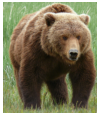

In [58]:
show_image(im.permute(1,2,0));

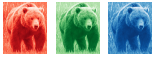

In [59]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(255-bear, ax=ax, cmap=color)

<img src="images/chapter9_rgbconv.svg" id="rgbconv" caption="Convolution over an RGB image" alt="Convolution over an RGB image" width="550">

These are then all added together, to produce a single number, for each grid location, for each output feature.

<img src="images/chapter9_rgb_conv_stack.svg" id="rgbconv2" caption="Adding the RGB filters" alt="Adding the RGB filters" width="500">

We have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels.

## Export -

In [60]:
import nbdev; nbdev.nbdev_export()